<a href="https://colab.research.google.com/github/DejiangZ/IoTLab04/blob/master/assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS576 Assignment #3: Object Detection Using YOLO v1
-----
Primary TA : Jaehoon Yoo (wogns98@kaist.ac.kr)

## Instruction
- In this assignment, you will implement, train, and test Yolo v1 on Pascal VOC Detection dataset with 20 object categories (`'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'`).

- For this, you need to implement (1) architecture, (2) loss function, (3) training/testing pipeline, and (4) inference function.

- In each part, you will be given a starter code for the implementation. Please read instructions carefully to implement the codes.  

- In this assignment, we will provide you with pre-trained weights of the Yolo architecture to reduce the amount of time required for the convergence and thus ease your burden on the training. This pre-trained weights will automatically loaded to your network if you implemented it correctly.

- **Make sure the downloaded files are properly placed under your root directory of your Google Drive**, so that the files are accessible at the directory `/gdrive/MyDrive/cs576_assign3` after mounting the drive.


## Submission guidelines
- Your code and report will be all in Colab.
- <font color="red"> You will get the full credit **only if** you complete the code **and** write a discussion of the results in the discussion section at the bottom of this page. Please refer to the discussion section for the details. </font>
- Also, please write discussion in <font color="red"> ENGLISH, not in Korean. </font>
- We should be able to reproduce your results using your code. Please double-check if your code runs without error and reproduces your results. Submissions failed to run or reproduce the results will get a substantial penalty.

## Deliverables
- Your Colab notebook with name of **[StudentID].ipynb**
- Result images (`1_result.jpg`, `2_result.jpg`, ...). Please refer to Problem 4.
- Saved checkpoint (`last.pth`). This will be saved automatically in your `checkpoints` directory.
- Submit all of them in a format as : **[StudentID].zip**.
- **If your submission doesn't contain all of the above deliverables , you will lose a point for deliverable (5pt).**
- Your assignment should be submitted through KLMS. All other submissions (e.g., via email) will not be considered as valid submissions.


## Due date
- **23:59:59 June 2nd.**
- Late submission is allowed until 23:59:59 June 4th.
- Late submission will be applied 20% penalty.

## Questions
- Please use "assignment3" channel in the SLACK channel as a main communication channel. When you post questions, please make it public so that all students can share the information.
- When you post questions, please avoid posting your own implementation (eg, posting the capture image of your own implementation.)

## Plagiarism
- <font color="red"> Do not copy public codes or your classmate's code. We will strictly detect the plagiarism. All codes with plagiarism will be considered as 0 point.

## Changelog

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
import os

# Specify the directory path where `assignemnt3.ipynb` and `dataset.zip` exist.
root = '/gdrive/MyDrive/cs576_assign3'
assert os.path.exists(os.path.join(root, 'dataset.zip')), "check if the files are correctly placed."

# run the following scripts only at the initialization of the machine
!ln -s {root}/data.py ./
!ln -sr {root}/weights ./
!unzip -q {root}/dataset.zip
!unzip -q {root}/test_images.zip

In [ ]:
import sys
sys.path.append(root)

import warnings
warnings.filterwarnings("ignore")

import os
import cv2
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms

from data import VOCDetection
def makedirs(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
# Configurations
run_name = 'vgg16'          # experiment name.
ckpt_root = 'checkpoints'   # from/to which directory to load/save checkpoints.
data_root = 'dataset'       # where the data exists.
pretrained_backbone_path = 'weights/pretrained_weight.pth'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.001          # learning rate
batch_size = 64     # batch_size
last_epoch = 0      # the last training epoch. (default: 0)
max_epoch = 10     # maximum epoch for the training.

num_boxes = 2       # the number of boxes for each grid in Yolo v1.
num_classes = 20    # the number of classes in Pascal VOC Detection.
grid_size = 7       # 3x224x224 image is reduced to (5*num_boxes+num_classes)x7x7.
lambda_coord = 7    # weight for coordinate regression loss.
lambda_noobj = 0.5  # weight for no-objectness confidence loss.

ckpt_dir = os.path.join(root, ckpt_root)
makedirs(ckpt_dir)
!ln -sr {ckpt_dir} ./

In [ ]:
train_dset = VOCDetection(root=data_root, split='train')
train_dloader = DataLoader(train_dset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=8)

test_dset = VOCDetection(root=data_root, split='test')
test_dloader = DataLoader(test_dset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=8)

# Problem 1. Implement Architecture (10pt) [(Illustration)](https://docs.google.com/drawings/d/1DNWgMK0XNQJ1IZPxX3u_ger7s-iQpAHG0pI_6A5dAPs/edit?usp=sharing)

In this section, you need to implement two modularized networks for Yolo v1:

(1) Backbone network of Yolo v1, extracting feature representations ($N, 512, 7, 7$) on input images ($N, 3, 224, 224$),  
(2) Detection network of Yolo v1, predicting object confidences, classes, and their locations based on grids ($N, S, S, B\times5+C$),

where $N, S, B, C$ refer to the batch size, grid size, the number of boxes for each grid, and the number of object classes, respectively.

For more details about the network architecture, please refer to the illustration.

Below, you will be provided with a skeleton python class for Yolo.  
Please fill in the `self.features = nn.Sequential(...)` and `self.detector = nn.Sequential(...)` to implement this module.

In [ ]:
class Yolo(nn.Module):
    def __init__(self, grid_size, num_boxes, num_classes):
        super(Yolo, self).__init__()
        self.S = grid_size
        self.B = num_boxes
        self.C = num_classes
        self.features = nn.Sequential(
            #-----------------YOUR CODE STARTS HERE-----------------#
            # P1.1. implement VGG16 backbone network here.
            #-----------------YOUR CODE ENDS HERE-----------------#
        )
        self.detector = nn.Sequential(
            #-----------------YOUR CODE STARTS HERE-----------------#
            # P1.2. implement detection head here.
            #-----------------YOUR CODE ENDS HERE-----------------#
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.detector(x)
        x = F.sigmoid(x)
        x = x.view(-1, self.S, self.S, self.B*5+self.C)
        return x


We provide the pretrained weights for backbone network (which will be frozen)  and also detection head (will be trained) to reduce training time. You can check your model implementation by checking whether the below weight loading code runs without problem.

In [ ]:
model = Yolo(grid_size, num_boxes, num_classes)
model = model.to(device)
pretrained_weights = torch.load(pretrained_backbone_path)
model.load_state_dict(pretrained_weights)

# It should print out <All keys matched successfully> when you implemented VGG correctly.

In [ ]:
# Freeze the backbone network.
model.features.requires_grad_(False)
model_params = [v for v in model.parameters() if v.requires_grad is True]
optimizer = optim.SGD(model_params, lr=lr, momentum=0.9, weight_decay=5e-4)

# Load the last checkpoint if exits.
ckpt_path = os.path.join(ckpt_dir.replace("\\", ""), 'last.pth')

if os.path.exists(ckpt_path):
    ckpt = torch.load(ckpt_path)
    model.load_state_dict(ckpt['model'], strict=False)
    optimizer.load_state_dict(ckpt['optimizer'])
    last_epoch = ckpt['epoch'] + 1
    print('Last checkpoint is loaded. start_epoch:', last_epoch)
else:
    print('No checkpoint is found.')

# Problem 2. Implement Loss Function (15pt)

In this section, you need to implement code for computing losses in Yolo.  
Below, you will be provided with a skeleton module class, where you need to complete the forward function:  
`def forward(self, pred_tensor, target_tensor):
...
return loss_xy, loss_wh, loss_obj, loss_noobj, loss_class`

where $N, S, B, C$ refer to the batch size, grid size, the number of boxes for each grid, and the number of object classes, respectively.

To get an easy picture on how `pred_tensor` and `target_tensor` look like, refer to the page 18~25 in [this slide](https://docs.google.com/presentation/d/1aeRvtKG21KHdD5lg6Hgyhx5rPq_ZOsGjG5rJ1HP7BbA/pub?start=false&loop=false&delayms=3000&slide=id.g137784ab86_4_1187)

Refer to the paper for more details about the loss function: https://arxiv.org/pdf/1506.02640.pdf

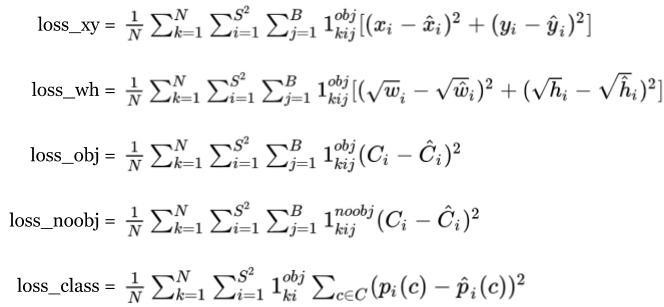

In [ ]:
class Loss(nn.Module):
    def __init__(self, grid_size=7, num_bboxes=2, num_classes=20):
        """ Loss module for Yolo v1.
        Use grid_size, num_bboxes, num_classes information if necessary.

        Args:
            grid_size: (int) size of input grid.
            num_bboxes: (int) number of bboxes per each cell.
            num_classes: (int) number of the object classes.
        """
        super(Loss, self).__init__()
        self.S = grid_size
        self.B = num_bboxes
        self.C = num_classes

    def compute_iou(self, bbox1, bbox2):
        """ Compute the IoU (Intersection over Union) of two set of bboxes, each bbox format: [x1, y1, x2, y2].
        Use this function if necessary.

        Args:
            bbox1: (Tensor) bounding bboxes, sized [N, 4].
            bbox2: (Tensor) bounding bboxes, sized [M, 4].
        Returns:
            (Tensor) IoU, sized [N, M].
        """
        N = bbox1.size(0)
        M = bbox2.size(0)

        # Compute left-top coordinate of the intersections
        lt = torch.max(
            bbox1[:, :2].unsqueeze(1).expand(N, M, 2), # [N, 2] -> [N, 1, 2] -> [N, M, 2]
            bbox2[:, :2].unsqueeze(0).expand(N, M, 2)  # [M, 2] -> [1, M, 2] -> [N, M, 2]
        )
        # Conpute right-bottom coordinate of the intersections
        rb = torch.min(
            bbox1[:, 2:].unsqueeze(1).expand(N, M, 2), # [N, 2] -> [N, 1, 2] -> [N, M, 2]
            bbox2[:, 2:].unsqueeze(0).expand(N, M, 2)  # [M, 2] -> [1, M, 2] -> [N, M, 2]
        )
        # Compute area of the intersections from the coordinates
        wh = rb - lt   # width and height of the intersection, [N, M, 2]
        wh[wh < 0] = 0 # clip at 0
        inter = wh[:, :, 0] * wh[:, :, 1] # [N, M]

        # Compute area of the bboxes
        area1 = (bbox1[:, 2] - bbox1[:, 0]) * (bbox1[:, 3] - bbox1[:, 1]) # [N, ]
        area2 = (bbox2[:, 2] - bbox2[:, 0]) * (bbox2[:, 3] - bbox2[:, 1]) # [M, ]
        area1 = area1.unsqueeze(1).expand_as(inter) # [N, ] -> [N, 1] -> [N, M]
        area2 = area2.unsqueeze(0).expand_as(inter) # [M, ] -> [1, M] -> [N, M]

        # Compute IoU from the areas
        union = area1 + area2 - inter # [N, M, 2]
        iou = inter / union           # [N, M, 2]

        return iou

    def forward(self, pred_tensor, target_tensor):
        """ Compute loss.

        Args:
            pred_tensor (Tensor): predictions, sized [batch_size, S, S, Bx5+C], 5=len([x, y, w, h, conf]).
            target_tensor (Tensor):  targets, sized [batch_size, S, S, Bx5+C].
        Returns:
            loss_xy (Tensor): localization loss for center positions (x, y) of bboxes.
            loss_wh (Tensor): localization loss for width, height of bboxes.
            loss_obj (Tensor): objectness loss.
            loss_noobj (Tensor): no-objectness loss.
            loss_class (Tensor): classification loss.
        """
        #-----------------YOUR CODE STARTS HERE-----------------#
        # P2. Write your code here
        #-----------------YOUR CODE ENDS HERE-----------------#
        return loss_xy, loss_wh, loss_obj, loss_noobj, loss_class


compute_loss = Loss(grid_size, num_boxes, num_classes)

# Problem 3. Implement Train/Test Pipeline (10pt)

In this section, you need to implement the entire train and test loop in the pipeline.

Specifically, you need to do the followings:
1. set proper device for the inputs (x) / labels (y).
2. feed inputs into the network, get outputs, compute loss using your implemented loss function from problem 2.   
(Don't forget to aggregate them all to calculate a single final loss, using lambda_coord and lambda_noobj).
    * For tensorboard logging, please define specified variable names for each subloss (loss_xy, loss_wh, loss_obj, loss_noobj, loss_class) and the total loss (loss) for training.
3. backward the computed loss and update network weights (only in the training loop).

* **Expected training + testing time using single T4 GPU (for reference)** : About 7 minutes / epoch.

**Note**: Since the training starts from already partially trained checkpoint, the loss curve will fluctuate instead of showing steady decrease. We will not grade your code based on the final performance, so do not worry.

In [ ]:
from tqdm.notebook import tqdm as tqdm2
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
import datetime

# for tensorboard record
log_dir = Path(root) / 'logs' / datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir.mkdir(parents=True, exist_ok=True)
writer = SummaryWriter(log_dir)

log_dir_ = str(log_dir).replace(" ", "\\ ")
%load_ext tensorboard
%tensorboard --logdir {log_dir_} --port 6007

# for best ckpt
best_ckpt_path = os.path.join(ckpt_dir, 'best.pth')
best_loss =  torch.load(best_ckpt_path)['val_loss'] if os.path.isfile(best_ckpt_path) else 5.0
print("start best_loss : {}".format(best_loss))

# Training & Testing.
model = model.to(device)
save_names = [name for name, v in model.named_parameters() if v.requires_grad is True]
global_step = 0
for epoch in range(max_epoch):
    # Learning rate scheduling
    if epoch in [195, 210]:
        lr *= 0.25
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    if epoch < last_epoch:
        continue

    model.train()
    batch_cnt = 0
    train_loss = 0.
    train_loss_sub = torch.zeros(size=(5,), dtype=torch.float, device=device)
    print("[{:02}/{:02}] epoch ==================== ".format(epoch + 1, max_epoch))
    for x, y in tqdm2(train_dloader):
        #-----------------YOUR CODE STARTS HERE-----------------#
        # P3.1. implement training pipeline here
        # ...
        # loss_xy, loss_wh, loss_obj, loss_noobj, loss_class = ...
        # loss = ...
        # ...
        #-----------------YOUR CODE ENDS HERE-----------------#

        # tensorboard record
        global_step += 1
        writer.add_scalar('train_loss/loss', loss, global_step)
        writer.add_scalar('train_loss/loss_xy', loss_xy.item(), global_step)
        writer.add_scalar('train_loss/loss_wh', loss_wh.item(), global_step)
        writer.add_scalar('train_loss/loss_obj', loss_obj.item(), global_step)
        writer.add_scalar('train_loss/loss_noobj', loss_noobj.item(), global_step)
        writer.add_scalar('train_loss/loss_class', loss_class.item(), global_step)

    train_loss /= batch_cnt
    train_loss_sub /= batch_cnt

    model.eval()
    batch_cnt = 0
    val_loss = 0.
    val_loss_sub = torch.zeros(size=(5,), dtype=torch.float, device=device)
    with torch.no_grad():
        for x, y in tqdm2(test_dloader):
            #-----------------YOUR CODE STARTS HERE-----------------#
            # P3.2. implement testing pipeline here
            #-----------------YOUR CODE ENDS HERE-----------------#

        val_loss = val_loss.item() / batch_cnt
        val_loss_sub /= batch_cnt

    # tensorboard record
    writer.add_scalar('val_loss/loss', val_loss, epoch + 1)
    writer.add_scalar('val_loss/loss_xy', val_loss_sub[0].item(), epoch + 1)
    writer.add_scalar('val_loss/loss_wh', val_loss_sub[1].item(), epoch + 1)
    writer.add_scalar('val_loss/loss_obj', val_loss_sub[2].item(), epoch + 1)
    writer.add_scalar('val_loss/loss_noobj', val_loss_sub[3].item(), epoch + 1)
    writer.add_scalar('val_loss/loss_class', val_loss_sub[4].item(), epoch + 1)

    # save last ckpt
    ckpt = {'model': {k: v for k, v in model.state_dict().items() if k in save_names}, # only save trainable params
            'optimizer': optimizer.state_dict(),
            'epoch': epoch}
    torch.save(ckpt, ckpt_path)

    # save best ckpt
    if val_loss < best_loss:
        best_loss = val_loss
        best_ckpt = {'model': {k: v for k, v in model.state_dict().items() if k in save_names}, # only save trainable params
                     'optimizer': optimizer.state_dict(),
                     'epoch': epoch,
                     'train_loss': train_loss,
                     'val_loss': val_loss}

        torch.save(best_ckpt, best_ckpt_path)

        # save best ckpt for submission (model params only)
        best_ckpt_for_submission = best_ckpt['model']
        torch.save(best_ckpt_for_submission, best_ckpt_path.replace('.pth', '_submission.pth'))

    # print loss
    print("train loss : {:.5f} {:.5f} {:.5f} {:.5f} {:.5f}".format(train_loss_sub[0].item(), train_loss_sub[1].item(),
                                                                    train_loss_sub[2].item(), train_loss_sub[3].item(),
                                                                    train_loss_sub[4].item()))
    print("val   loss : {:.5f} {:.5f} {:.5f} {:.5f} {:.5f}".format(val_loss_sub[0].item(), val_loss_sub[1].item(),
                                                                    val_loss_sub[2].item(), val_loss_sub[3].item(),
                                                                    val_loss_sub[4].item()))
    print("Total train loss : {:.5f} | Total val loss : {:.5f} | Best loss : {:.5f} \n".format(train_loss, val_loss, best_loss))


# Problem 4. Implement decoder to extract bounding boxes from output-grids (15pt)


In this section, you need to implement the decoder for extracting bounding boxes from given output grids ($S, S, B \times 5 + 20$). You should complete `decoder` function with given `NMS`(Non Max Suppression) function.

If you implement it well, you can perform object dection on the given image and get the result through `inference` function.

Check `test_images` directory and find `X_result.jpg` files if you succeeded to run `inference` function, and **attach these files in the discussion section**.

In [ ]:
VOC_CLASSES = (
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor')

def NMS(bboxes, scores, threshold=0.35):
    ''' Non Max Suppression
    Args:
        bboxes: (torch.tensors) list of bounding boxes. size:(N, 4) ((left_top_x, left_top_y, right_bottom_x, right_bottom_y), (...))
        probs: (torch.tensors) list of confidence probability. size:(N,)
        threshold: (float)
    Returns:
        keep_dim: (torch.tensors)
    '''
    x1 = bboxes[:, 0]
    y1 = bboxes[:, 1]
    x2 = bboxes[:, 2]
    y2 = bboxes[:, 3]

    areas = (x2 - x1) * (y2 - y1)

    _, order = scores.sort(0, descending=True)
    keep = []
    while order.numel() > 0:
        try:
            i = order[0]
        except:
            i = order.item()
        keep.append(i)

        if order.numel() == 1: break

        xx1 = x1[order[1:]].clamp(min=x1[i].item())
        yy1 = y1[order[1:]].clamp(min=y1[i].item())
        xx2 = x2[order[1:]].clamp(max=x2[i].item())
        yy2 = y2[order[1:]].clamp(max=y2[i].item())

        w = (xx2 - xx1).clamp(min=0)
        h = (yy2 - yy1).clamp(min=0)
        inter = w * h

        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        ids = (ovr <= threshold).nonzero().squeeze()
        if ids.numel() == 0:
            break
        order = order[ids + 1]
    keep_dim = torch.LongTensor(keep)
    return keep_dim

In [ ]:
def inference(model, image_path):
    """ Inference function
    Args:
        model: (nn.Module) Trained YOLO model.
        image_path: (str) Path for loading the image.
    """
    # load & pre-processing
    image_name = image_path.split('/')[-1]
    image = cv2.imread(image_path)

    h, w, c = image.shape
    img = cv2.resize(image, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img = transform(torch.from_numpy(img).float().div(255).transpose(2, 1).transpose(1, 0)) #Normalization
    img = img.unsqueeze(0)
    img = img.to(device)

    # inference
    output_grid = model(img).cpu()

    #### YOU SHOULD IMPLEMENT FOLLOWING decoder FUNCTION ####
    # decode the output grid to the detected bounding boxes, classes and probabilities.
    bboxes, class_idxs, probs = decoder(output_grid)
    num_bboxes = bboxes.size(0)

    # draw bounding boxes & class name
    for i in range(num_bboxes):
        bbox = bboxes[i]
        class_name = VOC_CLASSES[class_idxs[i]]
        prob = probs[i]

        x1, y1 = int(bbox[0] * w), int(bbox[1] * h)
        x2, y2 = int(bbox[2] * w), int(bbox[3] * h)

        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, '%s: %.2f'%(class_name, prob), (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 255), 1,
                    8)

    cv2.imwrite(image_path.replace('.jpg', '_result.jpg'), image)

In [ ]:
def decoder(grid):
    """ Decoder function that decode the output-grid to bounding box, class and probability.
    Args:
        grid: (torch.tensors) output grid from YOLO. size: (1, S, S, B*5 + 20)
    Returns:
        bboxes: (torch.tensors) list of bounding boxes. size:(N, 4) ((left_top_x, left_top_y, right_bottom_x, right_bottom_y), (...))
        class_idxs: (torch.tensors) list of class index. size:(N,)
        probs: (torch.tensors) list of confidence probability. size:(N,)
    """

    grid_num = 7
    bboxes = []
    class_idxs = []
    probs = []

    model.eval()
    grid = grid.squeeze()
    assert grid.size() == (grid_num, grid_num, num_boxes * 5 + num_classes)
    #-----------------YOUR CODE STARTS HERE-----------------#
    # P4 Implement the decoder function
    #-----------------YOUR CODE ENDS HERE-----------------#

    if len(bboxes) == 0: # Any box was not detected
        bboxes = torch.zeros((1,4))
        probs = torch.zeros(1)
        class_idxs = torch.zeros(1, dtype=torch.int)

    else:
        #list of tensors -> tensors
        bboxes = torch.cat(bboxes, dim=0)
        probs = torch.cat(probs, dim=0)
        class_idxs = torch.cat(class_idxs, dim=0)

    bboxes_result, class_idxs_result, probs_result = [], [], []
    for label in range(num_classes):
        label_mask = (class_idxs==label)
        if label_mask.sum() > 0:
            _bboxes = bboxes[label_mask]
            _probs = probs[label_mask]
            _class_idxs = class_idxs[label_mask]

            keep_dim = NMS(_bboxes, _probs, threshold=0.16) # Non Max Suppression
            bboxes_result.append(_bboxes[keep_dim])
            class_idxs_result.append(_class_idxs[keep_dim])
            probs_result.append(_probs[keep_dim])

    bboxes_result = torch.cat(bboxes_result, 0)
    class_idxs_result = torch.cat(class_idxs_result, 0)
    probs_result = torch.cat(probs_result, 0)

    return bboxes_result, class_idxs_result, probs_result

In [ ]:
test_image_dir = 'test_images'
image_path_list = [os.path.join(test_image_dir, f'{i}.jpg') for i in range(1, 11)]

best_ckpt = torch.load(best_ckpt_path)
model.load_state_dict(best_ckpt['model'], strict=False)
model.eval()

for image_path in image_path_list:
    inference(model, image_path)

# Discussion (15pt)
In this section, you should summarize your results with your analysis on them. Since implementation of YOLO is already dense, you don't need to conduct your own experiments this time. Instead, provide a disucssion on YOLO. At least, your discussion must include following items.
* Provide at least 3 result images (`1_image.jpg`, `2_image.jpg`, ...) and brief analysis on them (If it's working well, discuss the key to the success. If it's not working properly, discuss the possible reasons for the failure.)
* Analysis on why YOLO works so fast compared to its competitors (eg, RCNN, Fast-RCNN, Faster-RCNN).

In [ ]:
# This code cell is simple helper for visualization. Please provide your discussion in the next markdown cell.

import os
from IPython.display import display
import ipywidgets as widgets
from PIL import Image
import matplotlib.pyplot as plt

orig_files = sorted([
    fn for fn in os.listdir(test_image_dir)
    if fn.endswith('.jpg') and not fn.endswith('_result.jpg')
])

# ─── WIDGET SETUP ─────────────────────────────────────────────────────────
dropdown = widgets.Dropdown(
    options=orig_files,
    description='Select:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)
output = widgets.Output()

# ─── CALLBACK ─────────────────────────────────────────────────────────────
def show_pair(change):
    # only respond to selection changes
    if change['type'] == 'change' and change['name'] == 'value':
        base = change['new']
        res = base.replace('.jpg', '_result.jpg')

        # clear previous
        output.clear_output()
        with output:
            # load
            img1 = Image.open(os.path.join(test_image_dir, base))
            img2 = Image.open(os.path.join(test_image_dir, res))
            # plot side by side
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
            ax1.imshow(img1); ax1.set_title(base); ax1.axis('off')
            ax2.imshow(img2); ax2.set_title(res); ax2.axis('off')
            plt.tight_layout()
            plt.show()

# wire it up
dropdown.observe(show_pair)
display(dropdown, output)

# trigger initial display
show_pair({'type':'change','name':'value','new':dropdown.value})


**Discussion:** (Provide your discussion here)